## 클러스터링 분석 
##### 201921064 최요한  
사람이 자신의 건강상태를 아는 것은 검진을 받아야 정확히 알 수 있고  
그렇게 검진을 받아 나온 검진결과도 개인에 따라 해석하기 어려울 수 있습니다.    

그래서 가능한 보기 쉽게 개인의 건강 점수를 등급화하여 쉽게 나타내어  
개인이 자신의 건강 정도를 알기 쉽게 할 수 있게 하는 것이 목표입니다.  

  
“측정할 수 없으면 관리할 수 없고, 관리할 수 없으면 개선할 수 없다”라는 말이 있는 것처럼  
개인의 건강을 알아보기 쉬운 지표가 있다면 건강 관리에 도움이 될 것입니다.

###### 커널은 python 3.10.13을 사용했습니다.


In [ ]:
# !pip uninstall numpy --yes
# !pip install numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from module import categorize_bp, detect_outliers


### 데이터 선택 - 국민건강보험공단_건강검진정보  

건강검진정보는 해당연도에 건강검진을 수검한 국민건강보험 가입자 100만 명에 관한
기본정보(시도코드, 성별, 연령대 등)와 검진내역(신장, 체중, 혈압, 혈당, 총콜레스테롤, 혈색소 등)으로 구성된 데이터입니다.  
이미 많이 사용되었던 데이터인만큼 숨겨진 그룹을 찾는 것은 힘들 것 같습니다.

출처 : https://www.data.go.kr/data/15007122/fileData.do

### 데이터 불러오기 및 구조 확인

In [164]:
# 데이터 불러오기
file_path = "국민건강보험공단_건강검진정보_20221231.CSV"
data = pd.read_csv(file_path, encoding='cp949')  # 데이터가 한글을 포함하고 있어서 확장 완성형 인코딩 지정

# 데이터의 기본 정보 출력
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   기준년도         1000000 non-null  int64  
 1   가입자일련번호      1000000 non-null  int64  
 2   시도코드         1000000 non-null  int64  
 3   성별           1000000 non-null  int64  
 4   연령대코드(5세단위)  1000000 non-null  int64  
 5   신장(5cm단위)    1000000 non-null  int64  
 6   체중(5kg단위)    1000000 non-null  int64  
 7   허리둘레         999608 non-null   float64
 8   시력(좌)        999814 non-null   float64
 9   시력(우)        999815 non-null   float64
 10  청력(좌)        999885 non-null   float64
 11  청력(우)        999884 non-null   float64
 12  수축기혈압        994444 non-null   float64
 13  이완기혈압        994444 non-null   float64
 14  식전혈당(공복혈당)   994389 non-null   float64
 15  총콜레스테롤       345618 non-null   float64
 16  트리글리세라이드     345614 non-null   float64
 17  HDL콜레스테롤     345614 non-null   float64
 18  LDL

### 데이터 전처리

In [165]:
df = data.dropna()
df = df.reset_index(drop=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106876 entries, 0 to 106875
Data columns (total 30 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   기준년도         106876 non-null  int64  
 1   가입자일련번호      106876 non-null  int64  
 2   시도코드         106876 non-null  int64  
 3   성별           106876 non-null  int64  
 4   연령대코드(5세단위)  106876 non-null  int64  
 5   신장(5cm단위)    106876 non-null  int64  
 6   체중(5kg단위)    106876 non-null  int64  
 7   허리둘레         106876 non-null  float64
 8   시력(좌)        106876 non-null  float64
 9   시력(우)        106876 non-null  float64
 10  청력(좌)        106876 non-null  float64
 11  청력(우)        106876 non-null  float64
 12  수축기혈압        106876 non-null  float64
 13  이완기혈압        106876 non-null  float64
 14  식전혈당(공복혈당)   106876 non-null  float64
 15  총콜레스테롤       106876 non-null  float64
 16  트리글리세라이드     106876 non-null  float64
 17  HDL콜레스테롤     106876 non-null  float64
 18  LDL콜레스테롤     106876 non-

In [166]:
df.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'member_id',
    '시도코드': 'region_code',
    '성별': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '신장(5cm단위)': 'height',
    '체중(5kg단위)': 'weight',
    '허리둘레': 'waist_circumference',
    '시력(좌)': 'left_eye',
    '시력(우)': 'right_eye',
    '청력(좌)': 'left_ear',
    '청력(우)': 'right_ear',
    '수축기혈압': 'systolic_blood_pressure',
    '이완기혈압': 'diastolic_blood_pressure',
    '식전혈당(공복혈당)': 'fasting_blood_sugar',
    '총콜레스테롤': 'total_cholesterol',
    '트리글리세라이드': 'triglycerides',
    'HDL콜레스테롤': 'HDL_cholesterol',
    'LDL콜레스테롤': 'LDL_cholesterol',
    '혈색소': 'hemoglobin',
    '요단백': 'urine_protein',
    '혈청크레아티닌': 'serum_creatinine',
    '혈청지오티(AST)': 'serum_AST',
    '혈청지피티(ALT)': 'serum_ALT',
    '감마지티피': 'gamma_GTP',
    '흡연상태': 'smoking_status',
    '음주여부': 'alcohol_consumption',
    '구강검진수검여부': 'oral_exam_completion',
    '치아우식증유무': 'dental_caries',
    '치석': 'dental_plaque'
}, inplace=True) 

#원래는 의학 전문 용어가 있지만 편의를 위해 이렇게 번역했습니다.

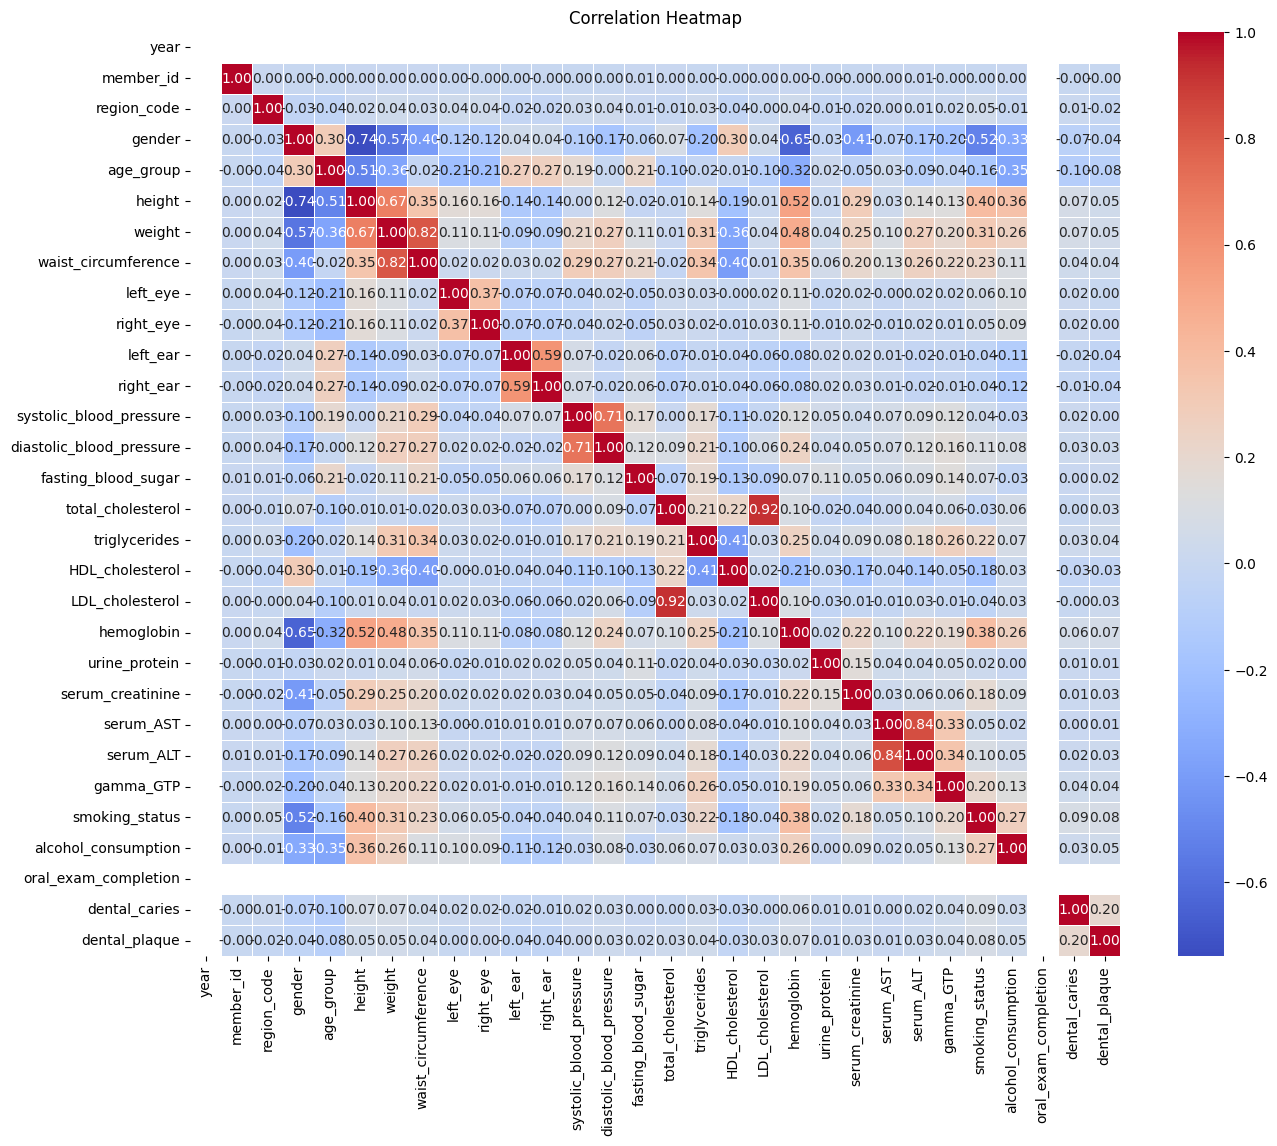

In [167]:
# 상관 행렬 계산
correlation_matrix = df.corr()

# 상관 행렬 시각화
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


 결측치가 하나라도 있는 행을 삭제하면서 모든 구강검진여부(oral_exam_copletion)의 값이 1이 되어  
 위와 같은 결과가 나타났습니다.

In [168]:
# 높은 상관 관계를 가지는 변수 쌍 추출
high_correlation = correlation_matrix[(correlation_matrix.abs() >= 0.5) & (correlation_matrix.abs() < 1)]

# 대각선을 기준으로 대칭인 상관 행렬에서 하나의 쌍만 선택
high_correlation = high_correlation.unstack().drop_duplicates()

# 높은 상관 관계를 가지는 변수 쌍 출력
print("높은 상관 관계를 가지는 변수 쌍:")
print(high_correlation)


높은 상관 관계를 가지는 변수 쌍:
year                     year                             NaN
gender                   height                     -0.738230
                         weight                     -0.570110
                         hemoglobin                 -0.648187
                         smoking_status             -0.515913
age_group                height                     -0.511264
height                   weight                      0.671522
                         hemoglobin                  0.520986
weight                   waist_circumference         0.815518
left_ear                 right_ear                   0.589433
systolic_blood_pressure  diastolic_blood_pressure    0.708346
total_cholesterol        LDL_cholesterol             0.923979
serum_AST                serum_ALT                   0.837869
dtype: float64


높은 상관계수를 가지는 혈청지오티(AST)와 혈청지오티(AST)와  
LDL 콜레스테롤과 총 콜레스테롤 사이의 클러스터링을 진행해보았습니다.

### 콜레스테롤과 혈청지오티

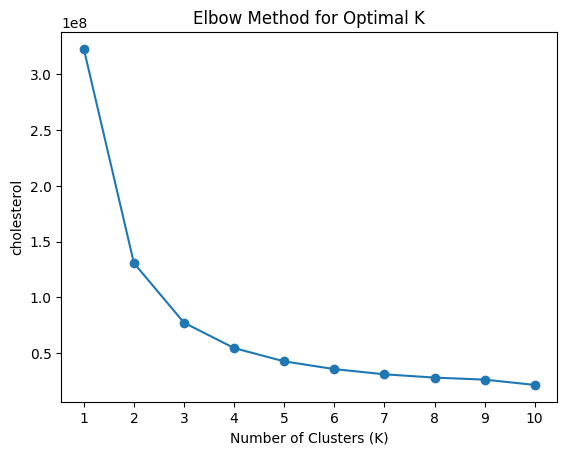

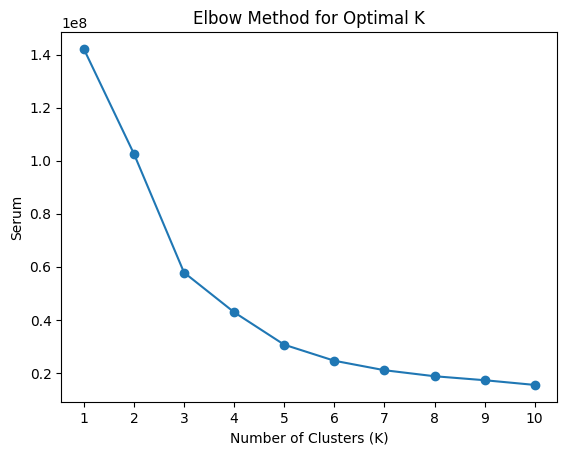

In [169]:
# 클러스터링할 변수 선택
features1 = ['LDL_cholesterol', 'total_cholesterol']

# 클러스터링을 위한 변수 선택
X = df[features1]


# 최대 클러스터 개수 설정
max_clusters = 10
# 클러스터 개수에 따른 클러스터 내 제곱 오차합 계산
ssw = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    ssw.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.plot(range(1, max_clusters + 1), ssw, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('cholesterol')
plt.xticks(np.arange(1, max_clusters + 1, step=1))
plt.show()


features2 = ['serum_ALT', 'serum_AST']
X = df[features2]

# 클러스터 개수에 따른 클러스터 내 제곱 오차합 계산
ssw = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    ssw.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.plot(range(1, max_clusters + 1), ssw, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Serum')
plt.xticks(np.arange(1, max_clusters + 1, step=1))
plt.show()

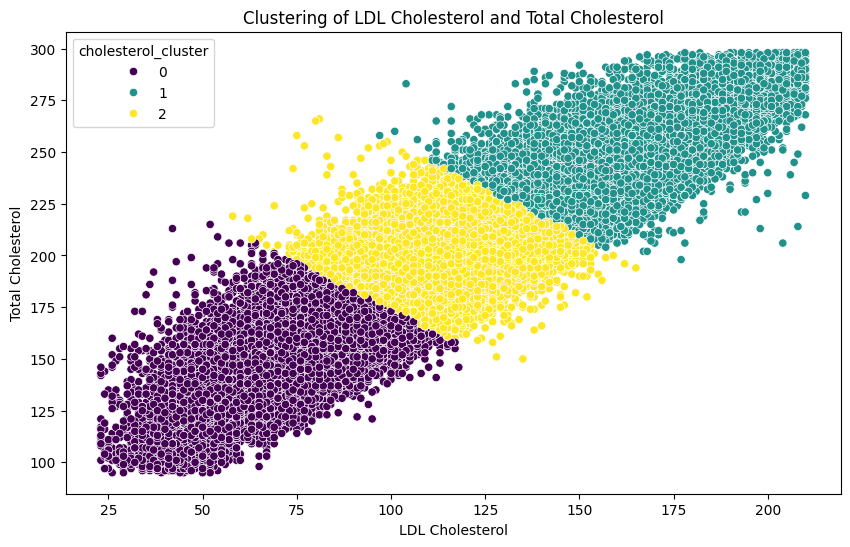

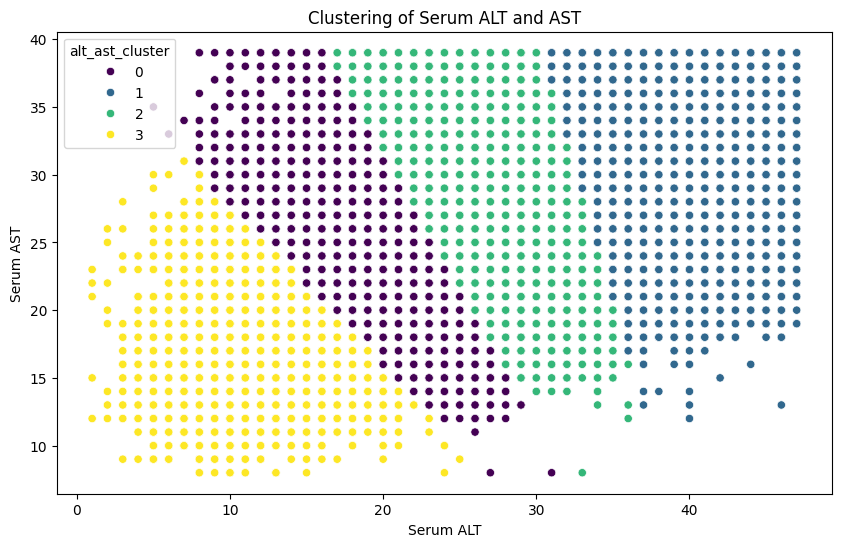

In [179]:
# 이상치 제거
outliers = detect_outliers(df, 'LDL_cholesterol')
df = df[~outliers]

outliers = detect_outliers(df, 'total_cholesterol')
df = df[~outliers]

outliers = detect_outliers(df, 'serum_ALT')
df = df[~outliers]

outliers = detect_outliers(df, 'serum_AST')
df = df[~outliers]



# LDL 콜레스테롤과 총 콜레스테롤에 대한 클러스터링
cholesterol_data = df[['LDL_cholesterol', 'total_cholesterol']]

kmeans_cholesterol = KMeans(n_clusters=3, random_state=42)
kmeans_cholesterol.fit(cholesterol_data)

# 클러스터링 결과를 데이터프레임에 추가
df['cholesterol_cluster'] = kmeans_cholesterol.labels_

# serum_ALT와 serum_AST에 대한 클러스터링
alt_ast_data = df[['serum_ALT', 'serum_AST']]

kmeans_alt_ast = KMeans(n_clusters=4, random_state=42)
kmeans_alt_ast.fit(alt_ast_data)

# 클러스터링 결과를 데이터프레임에 추가
df['alt_ast_cluster'] = kmeans_alt_ast.labels_

# 결과 확인을 위한 시각화
# LDL 콜레스테롤과 총 콜레스테롤에 대한 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LDL_cholesterol', y='total_cholesterol', hue='cholesterol_cluster', data=df, palette='viridis')
plt.title('Clustering of LDL Cholesterol and Total Cholesterol')
plt.xlabel('LDL Cholesterol')
plt.ylabel('Total Cholesterol')
plt.show()

# serum_ALT와 serum_AST에 대한 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='serum_ALT', y='serum_AST', hue='alt_ast_cluster', data=df, palette='viridis')
plt.title('Clustering of Serum ALT and AST')
plt.xlabel('Serum ALT')
plt.ylabel('Serum AST')
plt.show()


In [171]:
# 실루엣 점수 계산
cholesterol_silhouette_score = silhouette_score(cholesterol_data, kmeans_cholesterol.labels_)
alt_ast_silhouette_score = silhouette_score(alt_ast_data, kmeans_alt_ast.labels_)

print(f"LDL 콜레스테롤과 총 콜레스테롤에 대한 실루엣 점수: {cholesterol_silhouette_score}")
print(f"Serum ALT와 Serum AST에 대한 실루엣 점수: {alt_ast_silhouette_score}")

LDL 콜레스테롤과 총 콜레스테롤에 대한 실루엣 점수: 0.46917907171398715
Serum ALT와 Serum AST에 대한 실루엣 점수: 0.3587668725677628


둘 다 상관계수가 높은 데이터를 통해 진행해서인지 작지 않은 실루엣 점수가 나타나는 것을 알 수 있습니다.

    LDL 콜레스테롤과 총 콜레스테롤에 대한 실루엣 점수가 0.46으로 나타났습니다. 이는 상대적으로 높은 실루엣 점수로, 클러스터링 결과가 어느 정도 일관성을 가지고 있음을 나타냅니다. 이들 콜레스테롤 관련 변수는 클러스터링에 유용한 정보를 제공하는 것으로 보입니다.

    반면 Serum ALT와 Serum AST에 대한 실루엣 점수가 0.35로 나타났습니다. 이는 콜레스테롤과 비교했을 때 상대적으로 낮은 점수이며, 클러스터링 결과에 대한 일관성이 낮다는 것을 의미할 수 있습니다. 이들 변수는 클러스터링에 있어서 콜레스테롤 변수만큼 유용하지 않을 수 있습니다.

### 수축기혈압과 이완기혈압

마찬가지로 상관계수가 높은 수축기혈압과 이완기혈압을 통해 클러스터링을 하면 어떤 결과가 나올 지 궁금했습니다.  
고혈압과 저혈압에 맞게 잘 군집화할 수 있을 지 궁금했습니다.

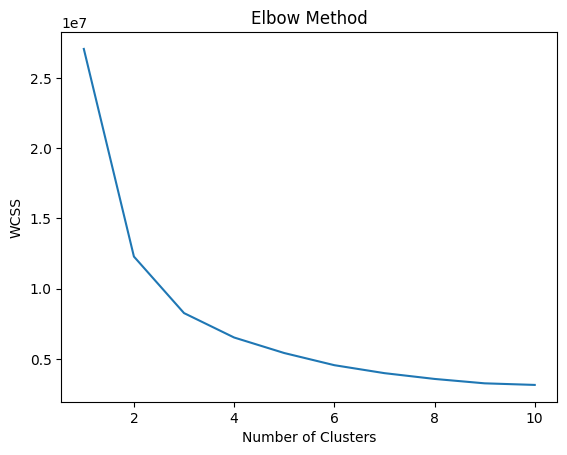

In [172]:


# 데이터 준비
X = df[['systolic_blood_pressure', 'diastolic_blood_pressure']].values

# 클러스터 수에 따른 이너셔 값(WCSS) 계산
wcss = []
for i in range(1, 11):  # 시도할 클러스터 수의 범위를 지정합니다 (1에서 10까지)
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # 이너셔 값을 리스트에 추가합니다

# 이너셔 값의 변화를 시각화합니다
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


blood_pressure_cluster
2    33373
0    33160
3    15253
1    12339
Name: count, dtype: int64


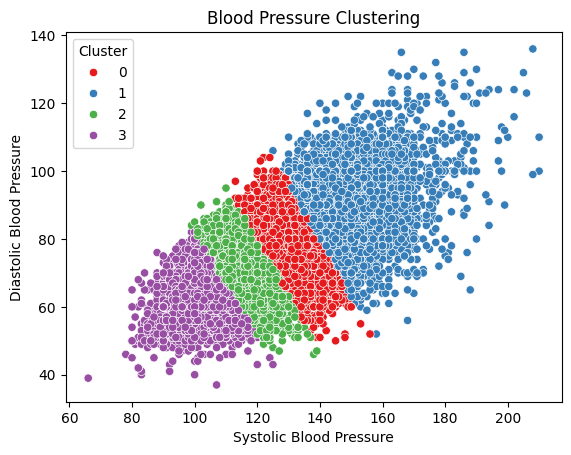

In [173]:
# 클러스터링을 위해 변환된 데이터 사용
blood_pressure_data = df[['systolic_blood_pressure', 'diastolic_blood_pressure']]

# K-means 모델 생성
kmeans = KMeans(n_clusters=4, random_state=42)
# 모델 학습
kmeans.fit(blood_pressure_data)

# 클러스터 레이블 할당
df['blood_pressure_cluster'] = kmeans.labels_
# 클러스터링 결과 출력
print(df['blood_pressure_cluster'].value_counts())

# 산점도 그리기
sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', hue='blood_pressure_cluster', data=df, palette='Set1')
plt.title('Blood Pressure Clustering')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='Cluster')
plt.show()

In [174]:
#실루엣 점수 계산
silhouette_avg = silhouette_score(blood_pressure_data, kmeans.labels_)
print("Blood Pressure Clustering의 실루엣 점수:", silhouette_avg)

Blood Pressure Clustering의 실루엣 점수: 0.3522959047094616


    실루엣 점수 : 0.3522

<img src="bp.png" width="500" height="400">  

위 표는 대한의학회, 질병관리본부에서 제공한 혈압을 바탕으로 한 진단표입니다.  
클러스터링 결과와 기준이 어느 정도 일치하는 지 알아보려 합니다.

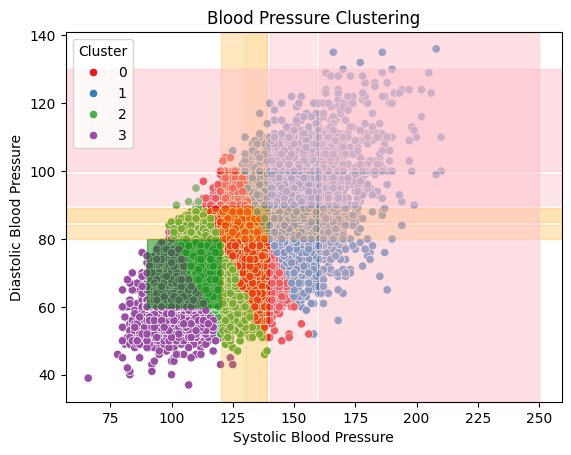

In [175]:
# 산점도 그리기
sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', hue='blood_pressure_cluster', data=df, palette='Set1')
plt.title('Blood Pressure Clustering')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='Cluster')

# 정상 범위 추가
intersection_x = (90, 120)
intersection_y = (60, 80)
plt.fill_between(intersection_x, intersection_y[0], intersection_y[1], color='green', alpha=0.5)
# 고혈압 전1기 범위 추가
plt.axvspan(120, 129, color='orange', alpha=0.25)  
plt.axhspan(80, 84, color='orange', alpha=0.25)    
# 고혈압 전2기 범위 추가
plt.axvspan(130, 139, color='orange', alpha=0.3)
plt.axhspan(85, 89, color='orange', alpha=0.3)    
# 고혈압 1기 범위 추가
plt.axvspan(140, 159, color='pink', alpha=0.4)  
plt.axhspan(90, 99, color='pink', alpha=0.4)    
# 고혈압 2기 범위 추가
plt.axvspan(160, 250, color='pink', alpha=0.5)  
plt.axhspan(100, 130, color='pink', alpha=0.5)    
# 수축기 단독 고혈압은 제외했습니다.

plt.show()

정상혈압은 초록색 범위로, 고혈압 전단계는 주황색으로, 고혈압은 분홍색으로 표시했습니다.  
어느 정도 잘 들어맞는 부분도 있는 듯 합니다.  
기준혈압을 (100 < 혈압 < 140)과 같이 수학적으로 정의내리다 보니 다소 딱딱한 느낌이 있는 것 같습니다. 

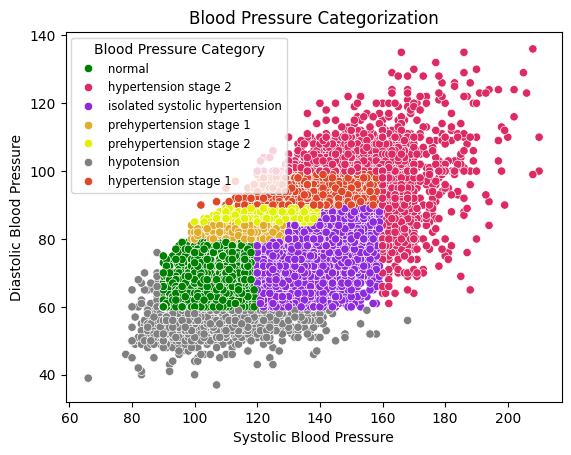

In [176]:
# 데이터에 범주화된 혈압 레이블 추가
df['blood_pressure_category'] = df.apply(lambda row: categorize_bp(row['systolic_blood_pressure'], row['diastolic_blood_pressure']), axis=1)

# 산점도 그리기
sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', hue='blood_pressure_category', data=df, palette={'normal': 'green', 'prehypertension stage 1': '#E1AC29', 'prehypertension stage 2': '#E1F101', 'hypertension stage 1': '#DF4728', 'hypertension stage 2': '#DE2A63', 'isolated systolic hypertension': '#8D2ADE', 'hypotension':'gray'})
plt.title('Blood Pressure Categorization')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='Blood Pressure Category', fontsize='small')
plt.show()


위 기준표에 맞게 카테고리화하고 색을 부여해 시각화해보았습니다.  
알아보기는 쉽지만 개인적으로 표본들 모양이 y=x 방향의 고구마같지만  
딱딱한 기준에 의해 네모낳게 분류되어 다른 방법으로도 군집화해보려고 합니다.

blood_pressure_cluster
0    21684
2    18636
3    15590
4    12114
6    11424
1    11001
5     3676
Name: count, dtype: int64


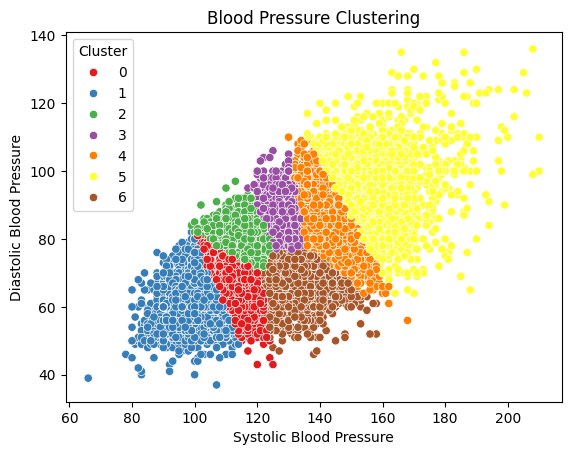

In [177]:
# 초기 클러스터 중심 지정
init_centers = np.array([[105, 70], [50, 80], [125, 82], [135, 87], [150, 95], [175,105], [140,70]])

# KMeans 알고리즘 실행
kmeans = KMeans(n_clusters=7, init=init_centers, n_init=1)


# 클러스터링을 위해 변환된 데이터 사용
blood_pressure_data = df[['systolic_blood_pressure', 'diastolic_blood_pressure']]
# 모델 학습
kmeans.fit(blood_pressure_data)

# 클러스터 레이블 할당
df['blood_pressure_cluster'] = kmeans.labels_
# 클러스터링 결과 출력
print(df['blood_pressure_cluster'].value_counts())

# 산점도 그리기
sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', hue='blood_pressure_cluster', data=df, palette='Set1')
plt.title('Blood Pressure Clustering')
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.legend(title='Cluster')
plt.show()

경계가 부드럽게 나뉘지 않는다는 점이 조금 아쉽지만 전 그래프보다는 부드럽게 기준을 나눌 수 있지 않을까 싶습니다.  
어쩌면 이렇게 나눴을 때 고혈압과 저혈압의 진단 기준을 좀 더 자연스럽게 정의내릴 수 있지 않을까 싶습니다.  

하지만 혈압이라는 것은 사람의 건강과 직결된 문제이므로 단순히 그래프를 보기 좋게 하기 위해서보다는  
적절한 기준에 따라 분류하고 검진을 내려야 할 것 같다는 생각이 들었습니다. 

In [178]:
# 실루엣 점수 계산
silhouette_avg = silhouette_score(blood_pressure_data, kmeans.labels_)
print("Blood Pressure Clustering의 실루엣 점수:", silhouette_avg)

Blood Pressure Clustering의 실루엣 점수: 0.33551782173644246


    실루엣 점수 0.3355

사람이 자신의 건강 정도를 알기 힘들고 결과를 보기 쉽게 클러스터링하여 등급화하고 싶었지만  
건강하다를 정의내리기 쉽지 않았고, 딴 길로 새다보니 시간이 부족해 제대로 결과가 도출하지는 못했습니다.  
높은 상관관계를 가진 변수와 클러스터링 그래프를 보기 좋게 나오게 하는 것에만 너무 집중했던 것 같습니다.